In [93]:
import pandas as pd
from scipy import stats
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [94]:
incident = pd.read_csv('../data/processed/incident_14_22.csv')
incident.head()

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,call_hour,call_day,call_month,call_year
0,2014-08-05 00:51:11,Other type of accidental fire,High Risk,FIRE,1,0,429008.867960,279466.431647,78,81,267.0,0,1,8,2014
1,2014-08-05 01:53:23,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,400060.417513,291291.512584,57,104,175.0,1,1,8,2014
2,2014-08-05 02:04:43,Gas leak,High Risk,SSC,2,0,397304.803476,289145.924308,102,149,311.0,2,1,8,2014
3,2014-08-05 02:09:56,False alarm raised with good intent,False Alarms,FALSE_ALARM,0,1,404480.191871,289576.642513,70,85,393.0,2,1,8,2014
4,2014-08-05 02:59:36,Deliberate Rubbish Fires,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,433324.298276,282473.140722,54,278,156.0,2,1,8,2014


In [95]:
print(incident.describe())

           prl_count      brv_count       EASTINGS      NORTHINGS  \
count  219926.000000  219926.000000  219926.000000  219926.000000   
mean        0.859821       0.493398  406509.368567  288784.079032   
std         0.906735       0.519800   12051.328379    7014.123106   
min         0.000000       0.000000  386159.376502  272135.394576   
25%         0.000000       0.000000  398064.465872  283391.547720   
50%         1.000000       0.000000  405022.851969  288036.498892   
75%         1.000000       1.000000  411429.394776  293871.458996   
max        34.000000      13.000000  439383.984557  307318.670460   

        call_seconds  reaction_seconds  driving_seconds      call_hour  \
count  219926.000000     219926.000000    219926.000000  219926.000000   
mean      136.034712         73.607918       298.035607      13.996317   
std      1526.065871        205.535917       466.539120       6.272446   
min         0.000000          0.000000         0.000000       0.000000   
25%     

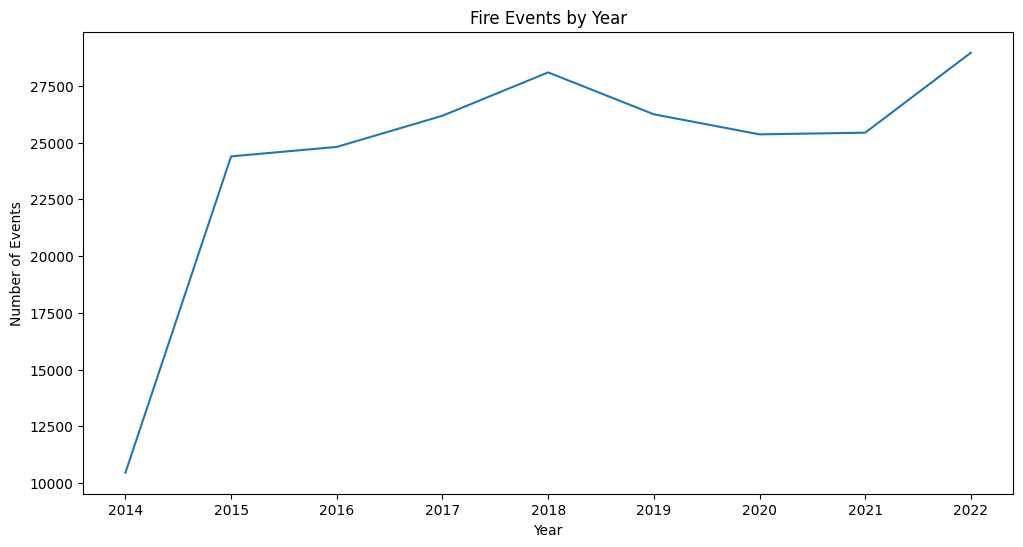

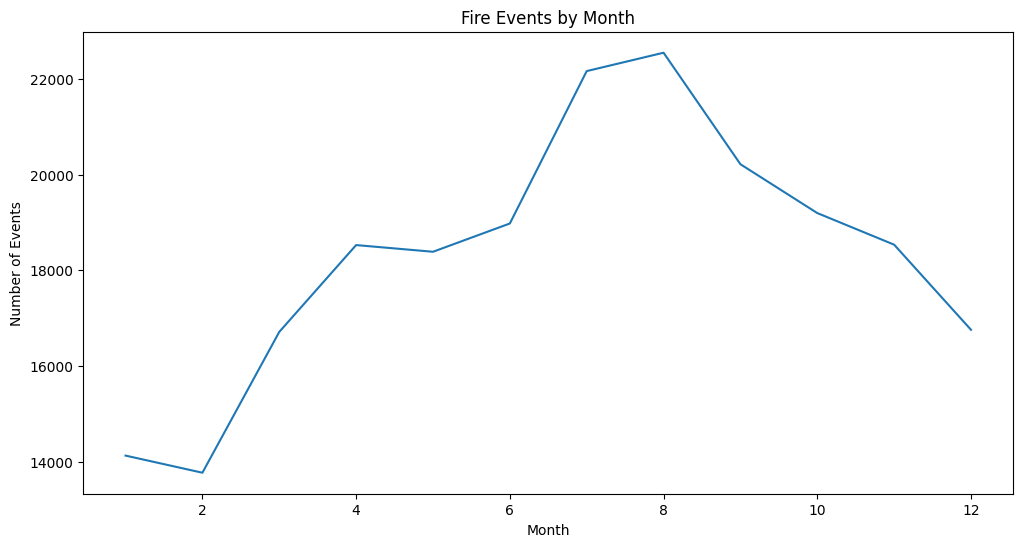

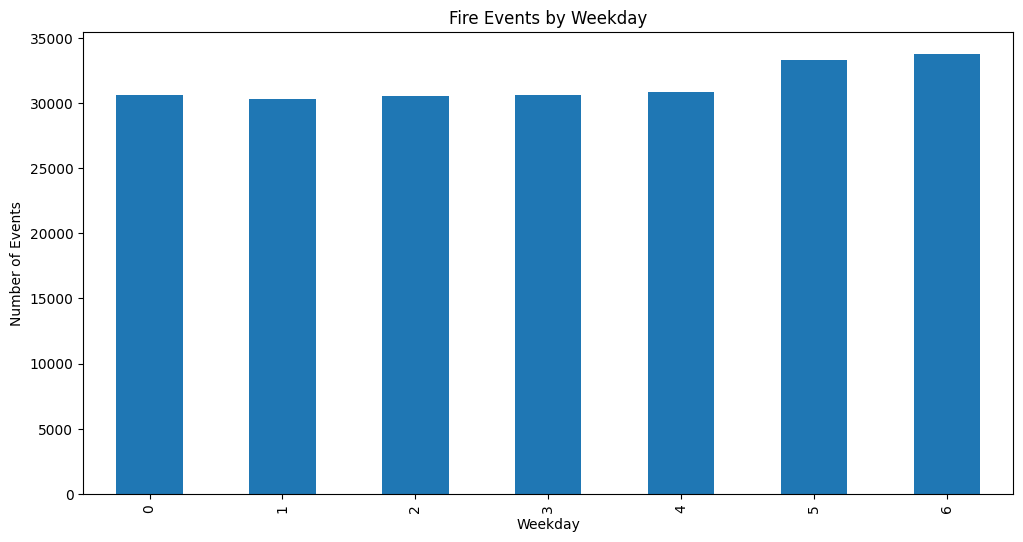

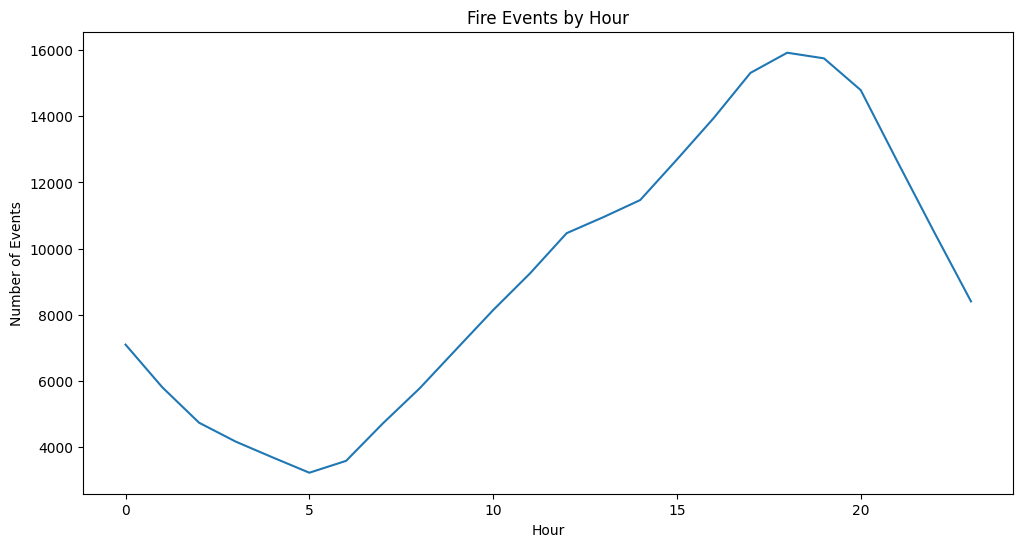

In [96]:
yearly_counts = incident['call_year'].value_counts().sort_index()
yearly_counts.plot(kind='line', figsize=(12, 6), title='Fire Events by Year')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.show()

monthly_counts = incident['call_month'].value_counts().sort_index()
monthly_counts.plot(kind='line', figsize=(12, 6), title='Fire Events by Month')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.show()

weekday_counts = incident['call_day'].value_counts().sort_index()
weekday_counts.plot(kind='bar', figsize=(12, 6), title='Fire Events by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Events')
plt.show()

hourly_counts = incident['call_hour'].value_counts().sort_index()
hourly_counts.plot(kind='line', figsize=(12, 6), title='Fire Events by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Events')
plt.show()

incident level: False Alarms


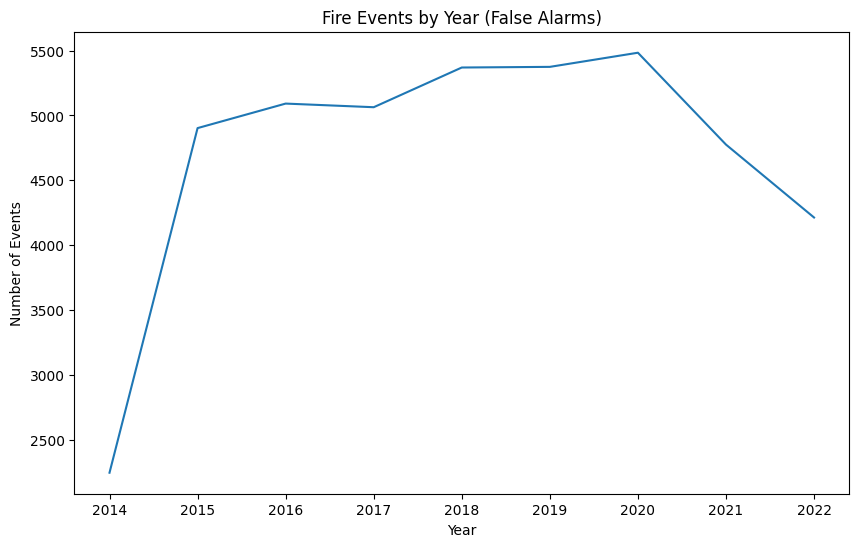

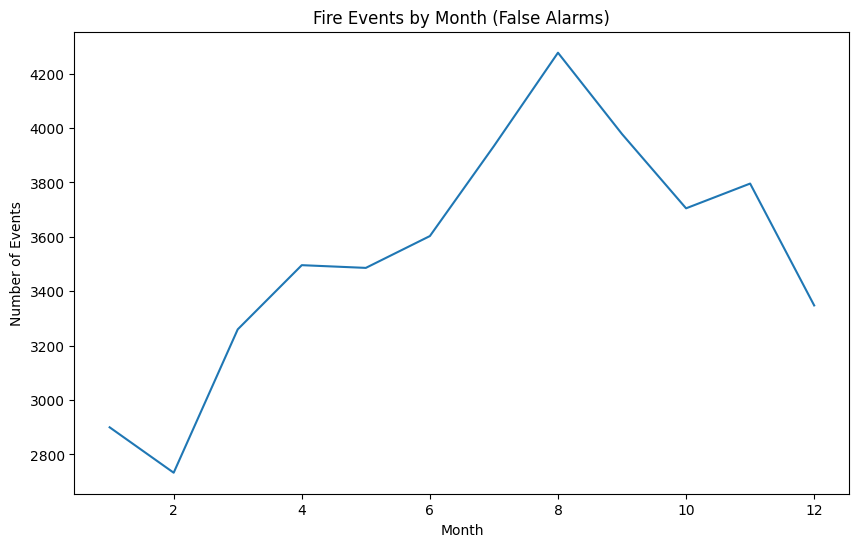

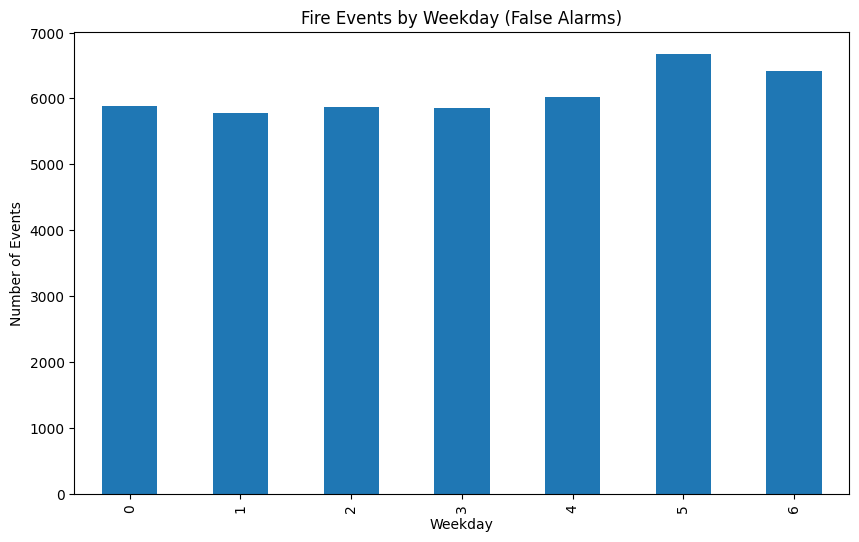

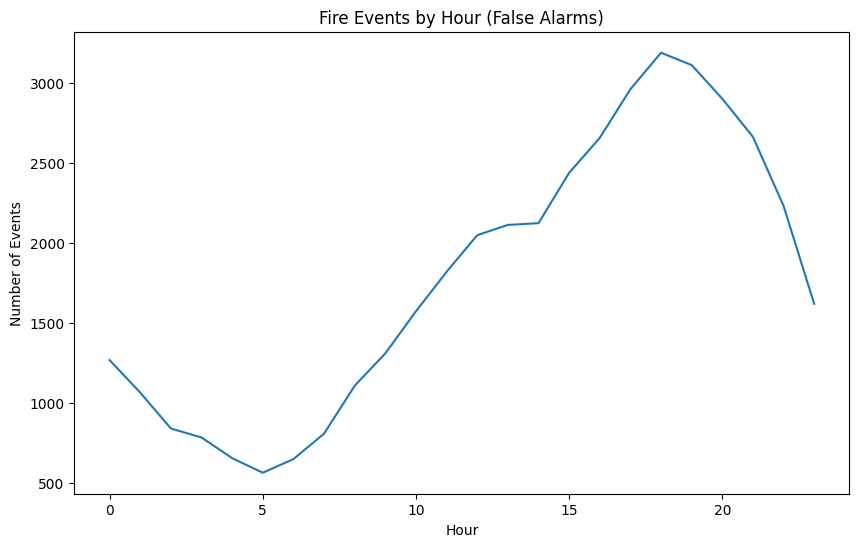

incident level: High Risk


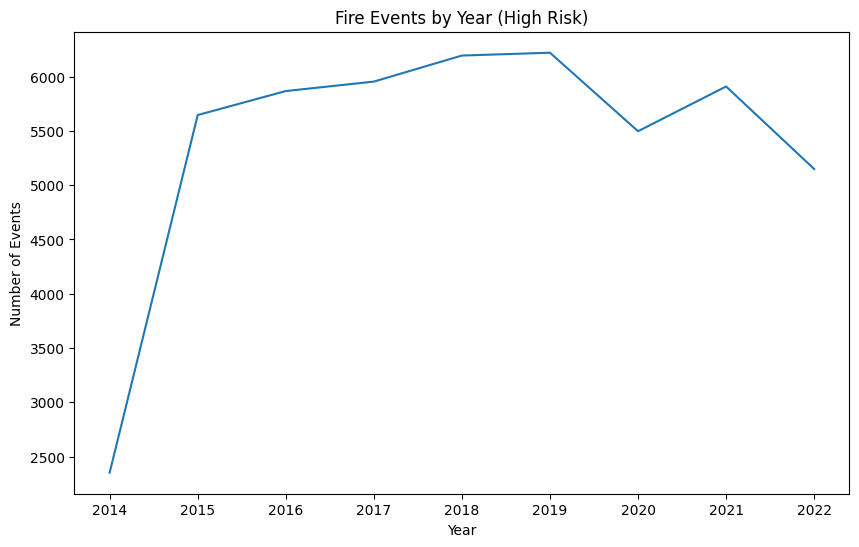

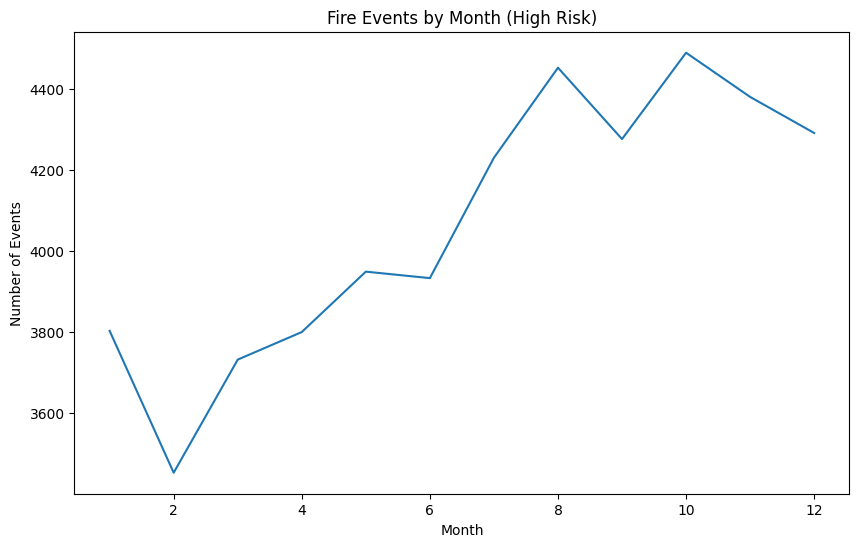

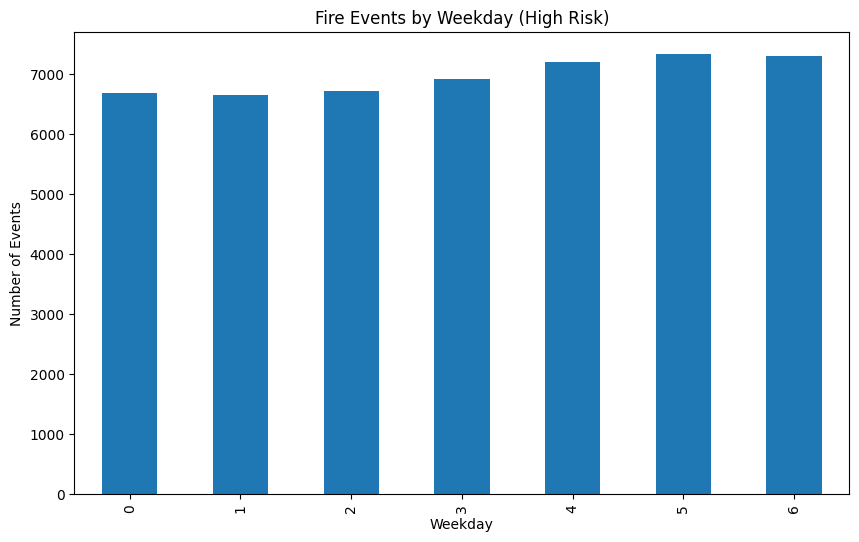

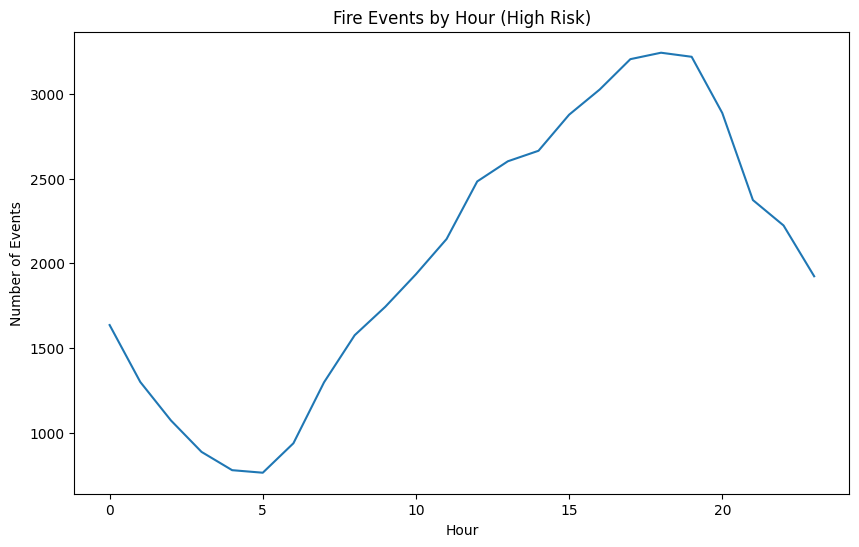

incident level: Low Risk


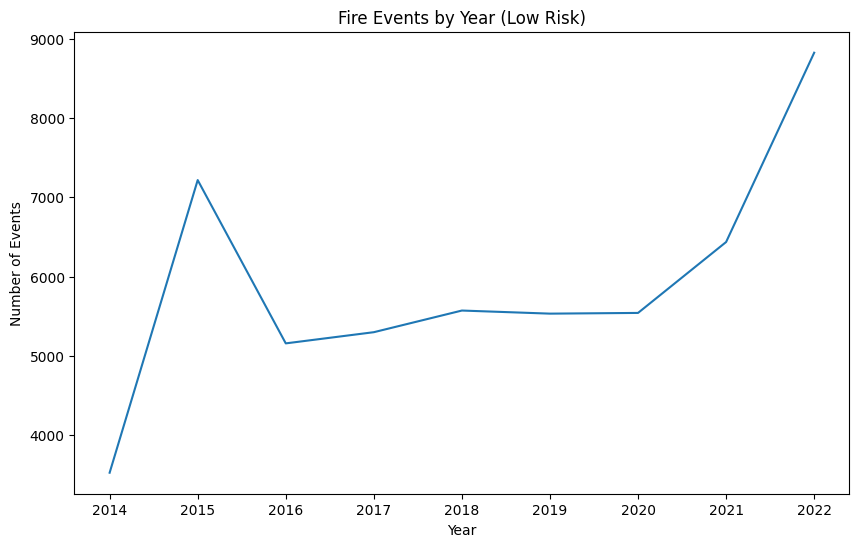

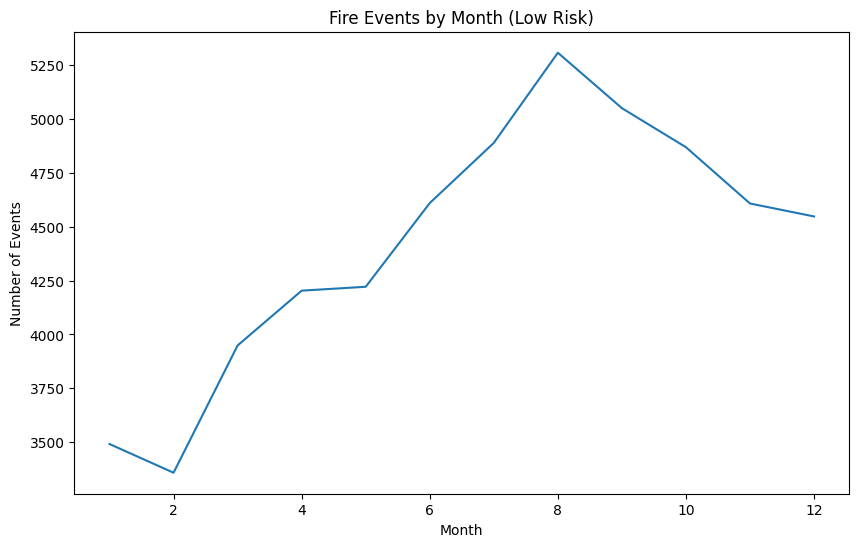

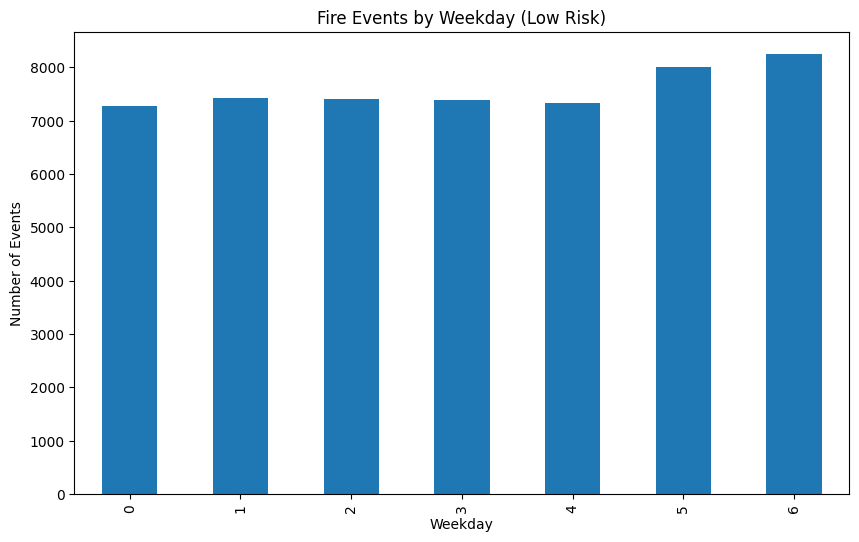

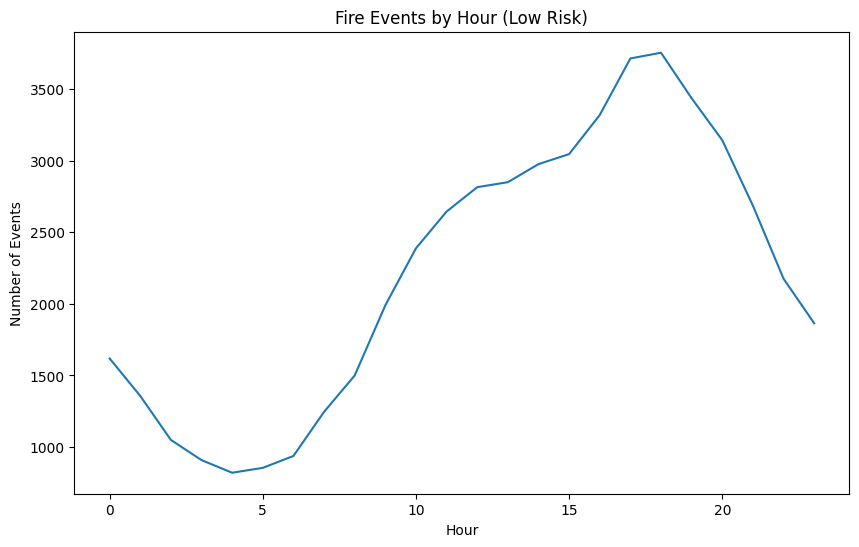

incident level: Medium Risk


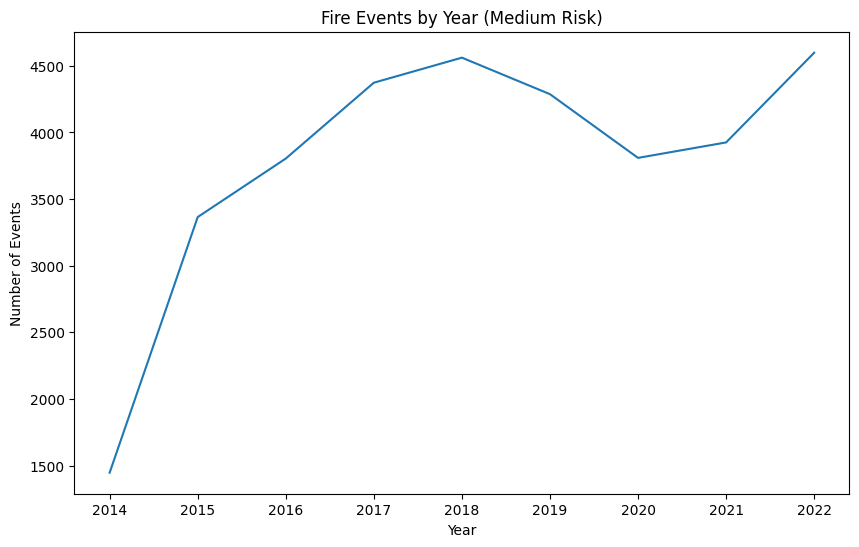

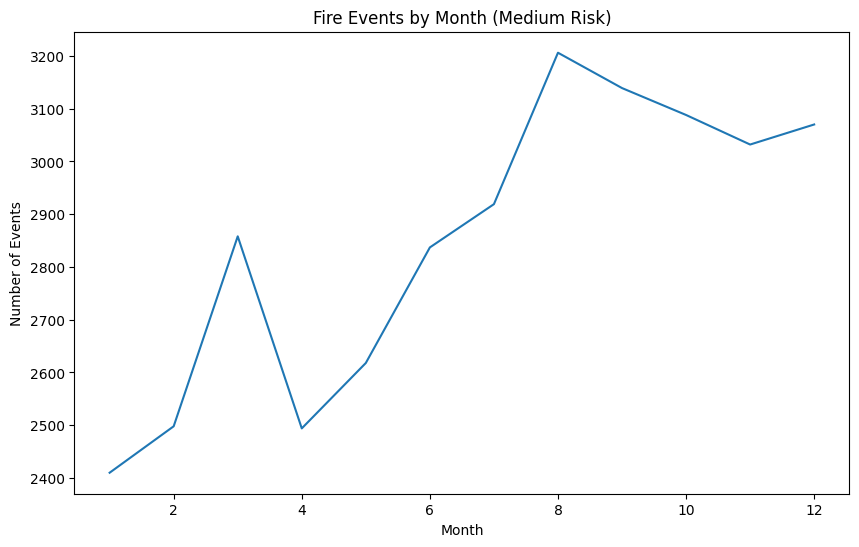

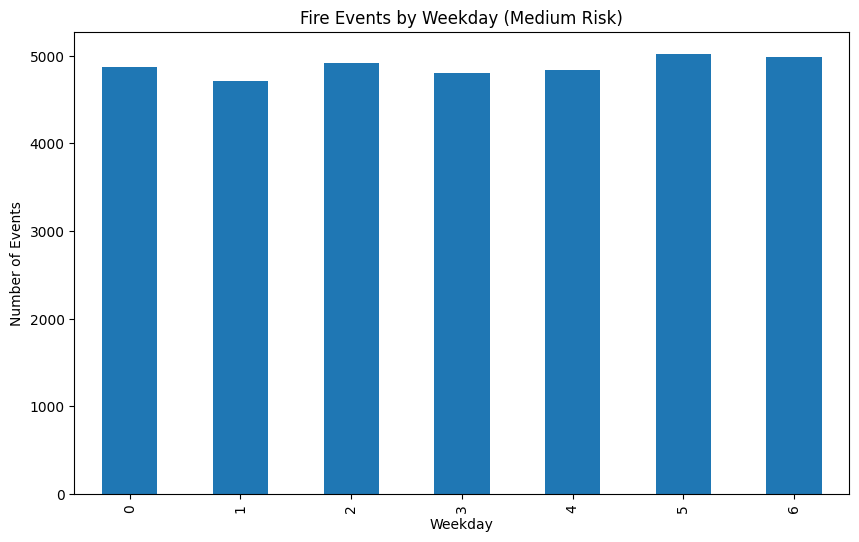

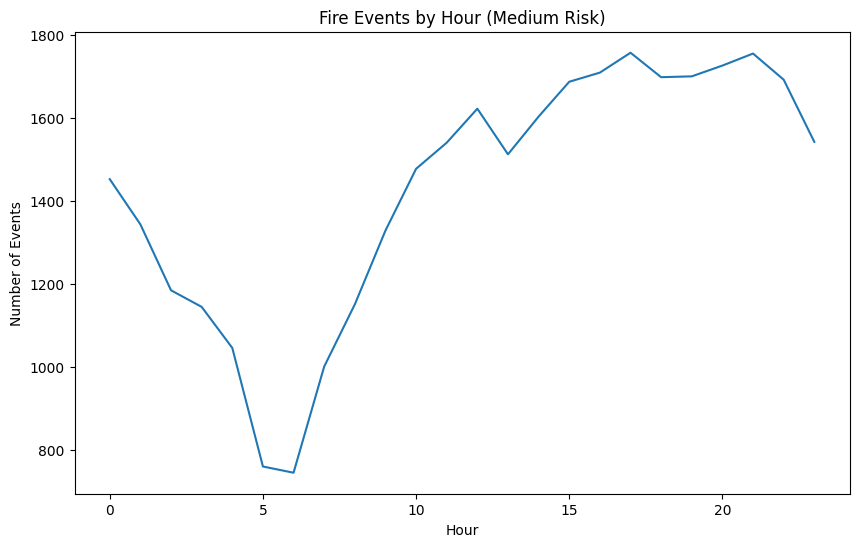

incident level: Secondary Fires that attract a 20 minute-response time


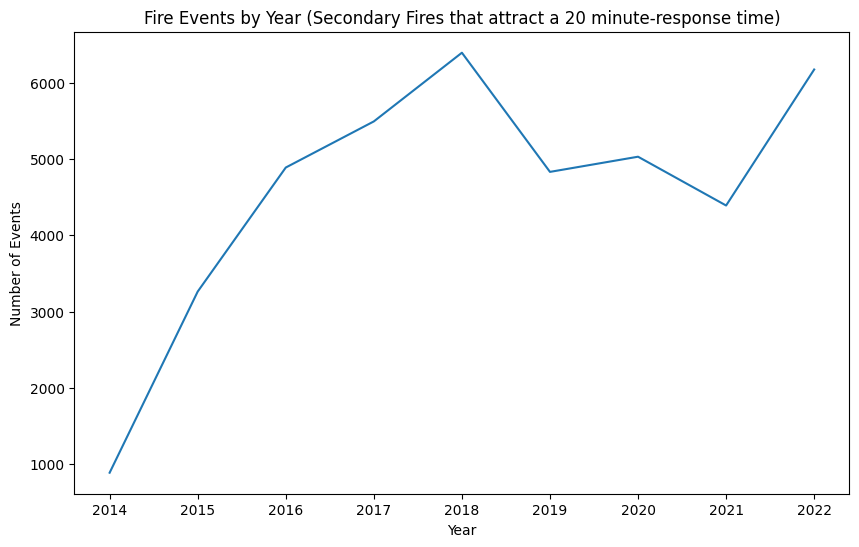

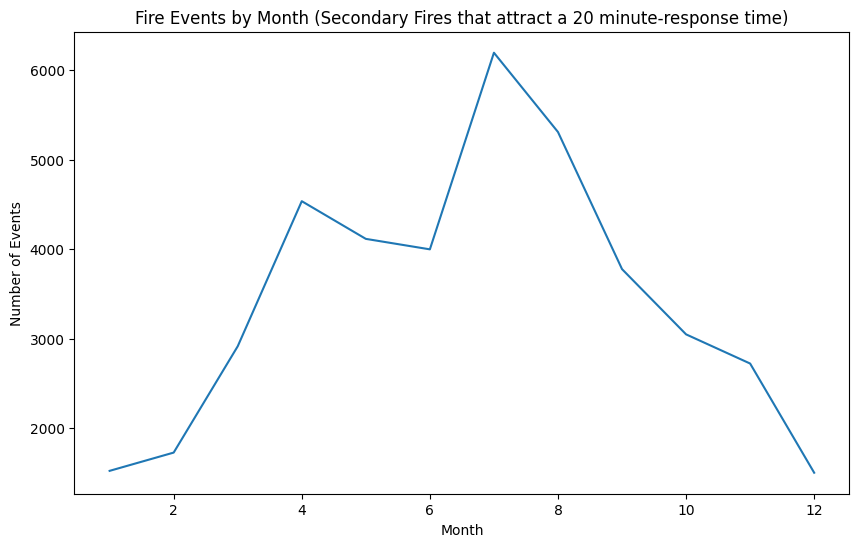

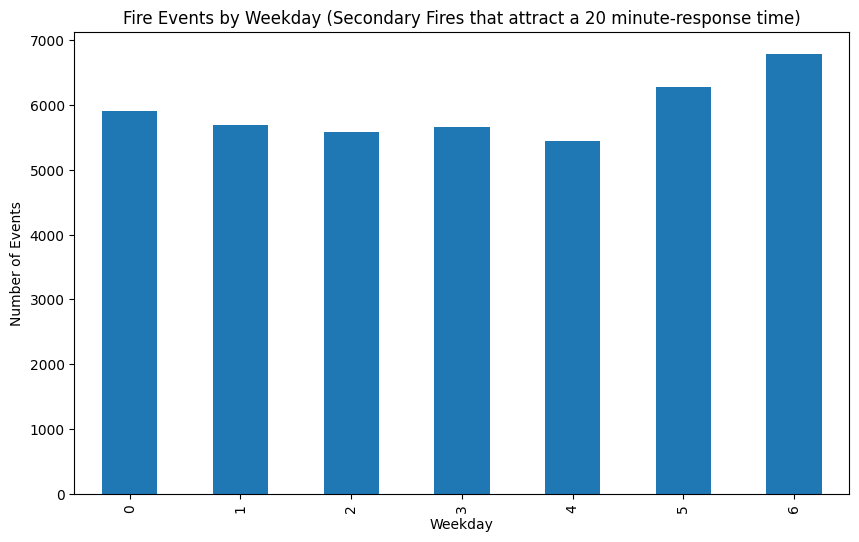

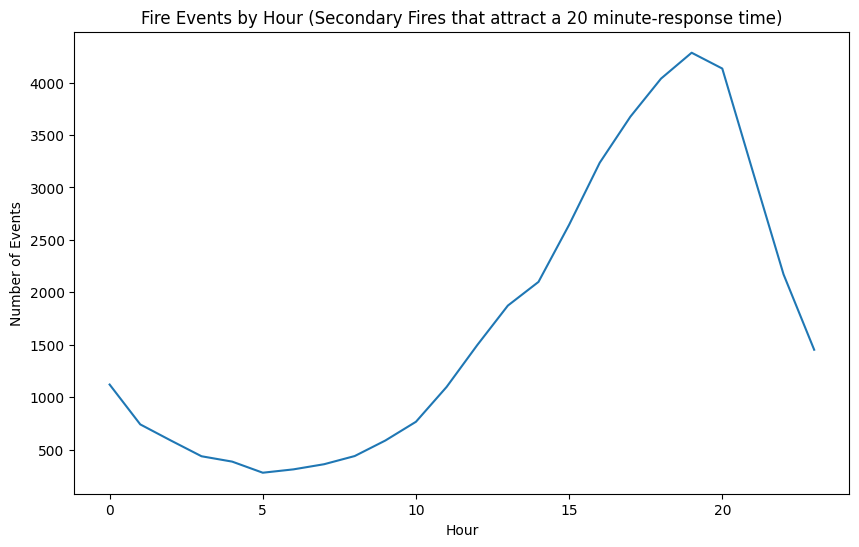

In [97]:
# different incident profiles
incident_profiles = incident.groupby('incident_profile_label')

for profile, group in incident_profiles:
    print(f"incident level: {profile}")
    
    yearly_counts = group['call_year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    yearly_counts.plot(kind='line')
    plt.title(f'Fire Events by Year ({profile})')
    plt.xlabel('Year')
    plt.ylabel('Number of Events')
    plt.show()

    monthly_counts = group['call_month'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    monthly_counts.plot(kind='line')
    plt.title(f'Fire Events by Month ({profile})')
    plt.xlabel('Month')
    plt.ylabel('Number of Events')
    plt.show()
    
    weekday_counts = group['call_day'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    weekday_counts.plot(kind='bar')
    plt.title(f'Fire Events by Weekday ({profile})')
    plt.xlabel('Weekday')
    plt.ylabel('Number of Events')
    plt.show()
    
    hourly_counts = group['call_hour'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    hourly_counts.plot(kind='line')
    plt.title(f'Fire Events by Hour ({profile})')
    plt.xlabel('Hour')
    plt.ylabel('Number of Events')
    plt.show()

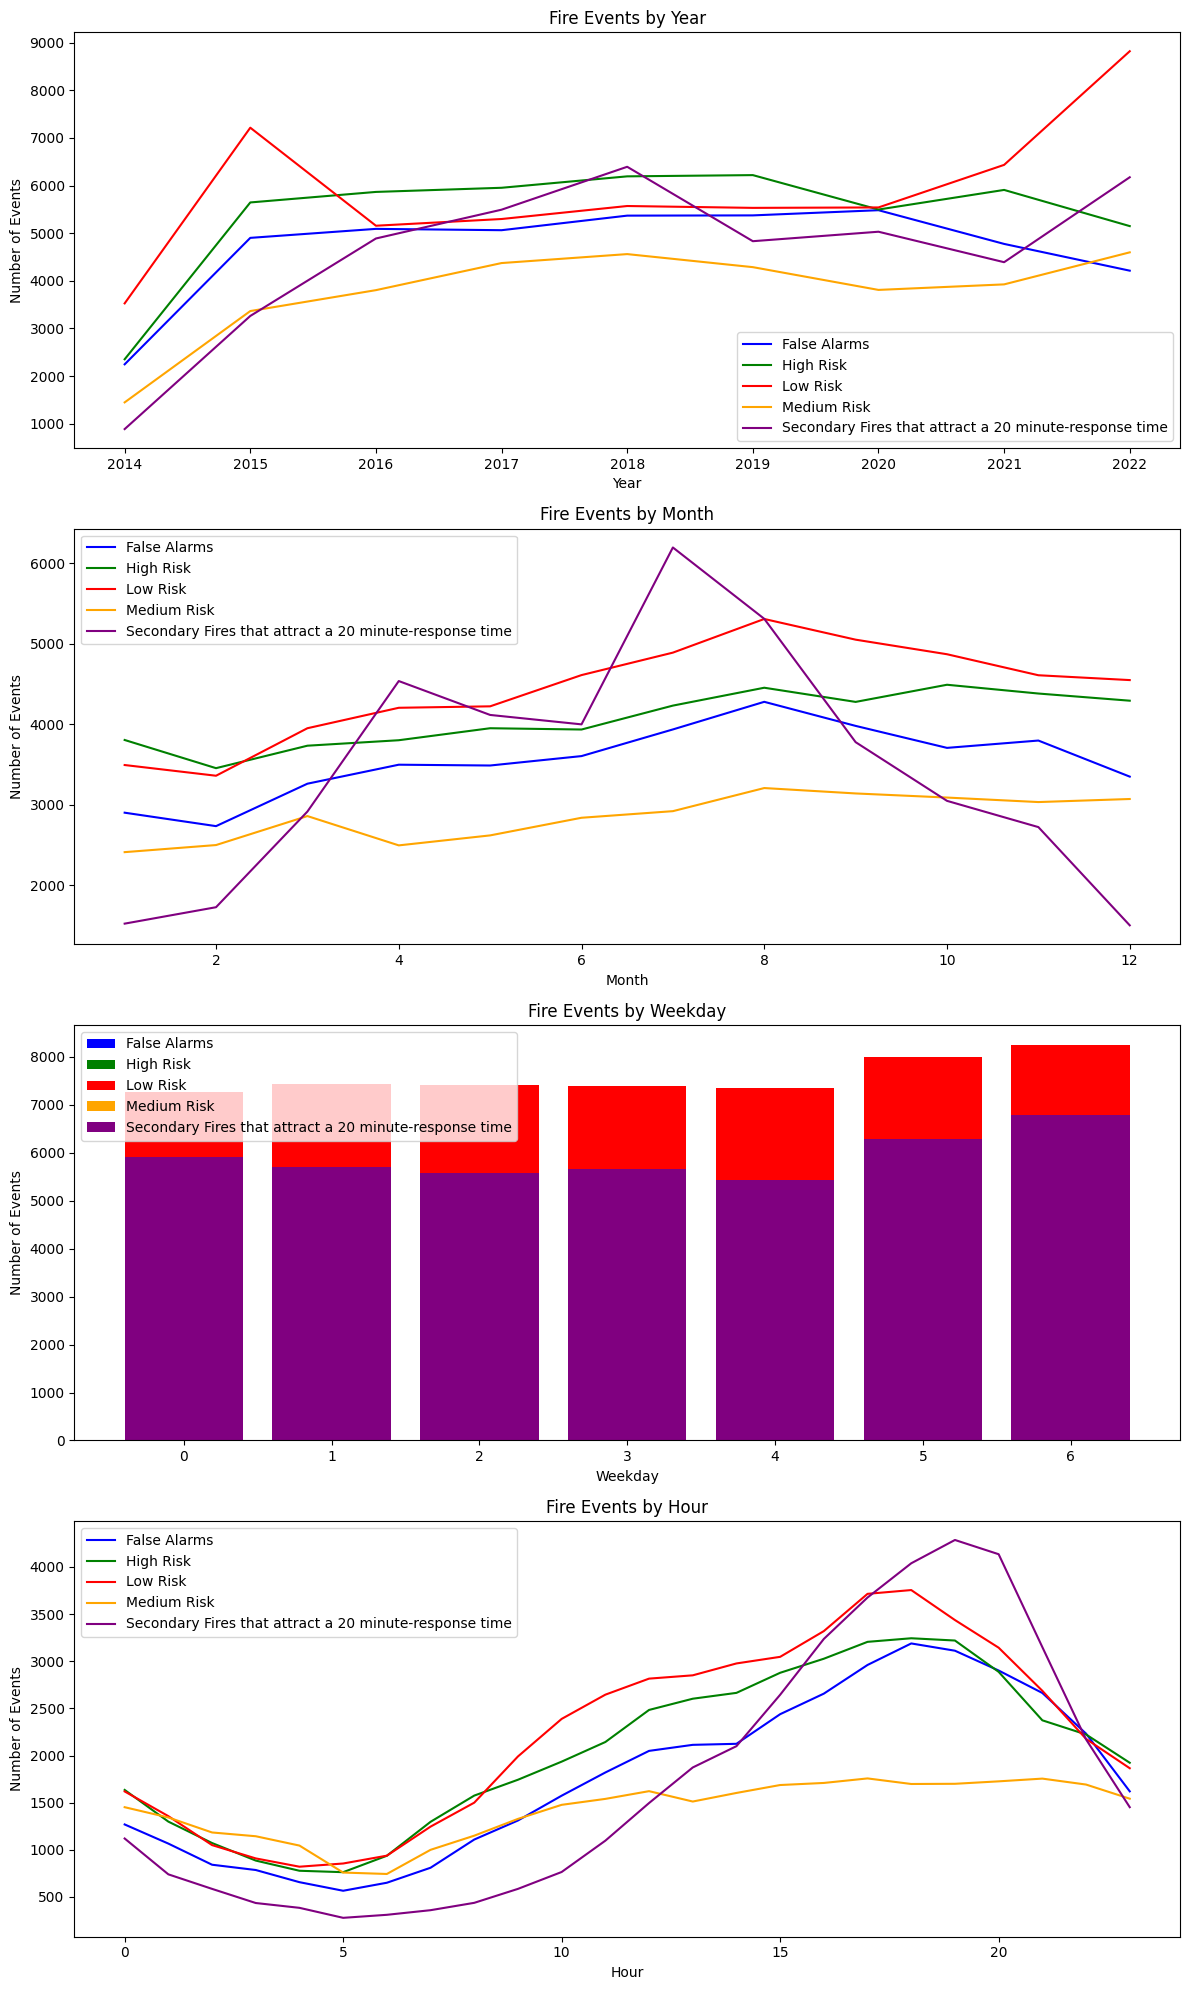

In [98]:
fig, axs = plt.subplots(4, figsize=(12, 20))
colors = ['blue', 'green', 'red', 'orange', 'purple']

for idx, (profile, group) in enumerate(incident_profiles):

    yearly_counts = group['call_year'].value_counts().sort_index()
    axs[0].plot(yearly_counts.index, yearly_counts.values, label=profile, color=colors[idx])

    monthly_counts = group['call_month'].value_counts().sort_index()
    axs[1].plot(monthly_counts.index, monthly_counts.values, label=profile, color=colors[idx])

    weekday_counts = group['call_day'].value_counts().sort_index()
    axs[2].bar(weekday_counts.index, weekday_counts.values, label=profile, color=colors[idx])

    hourly_counts = group['call_hour'].value_counts().sort_index()
    axs[3].plot(hourly_counts.index, hourly_counts.values, label=profile, color=colors[idx])

axs[0].set_title('Fire Events by Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Events')
axs[0].legend()
axs[1].set_title('Fire Events by Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Number of Events')
axs[1].legend()
axs[2].set_title('Fire Events by Weekday')
axs[2].set_xlabel('Weekday')
axs[2].set_ylabel('Number of Events')
axs[2].legend()
axs[3].set_title('Fire Events by Hour')
axs[3].set_xlabel('Hour')
axs[3].set_ylabel('Number of Events')
axs[3].legend()

plt.tight_layout()
plt.show()


Seasonal Decomposition

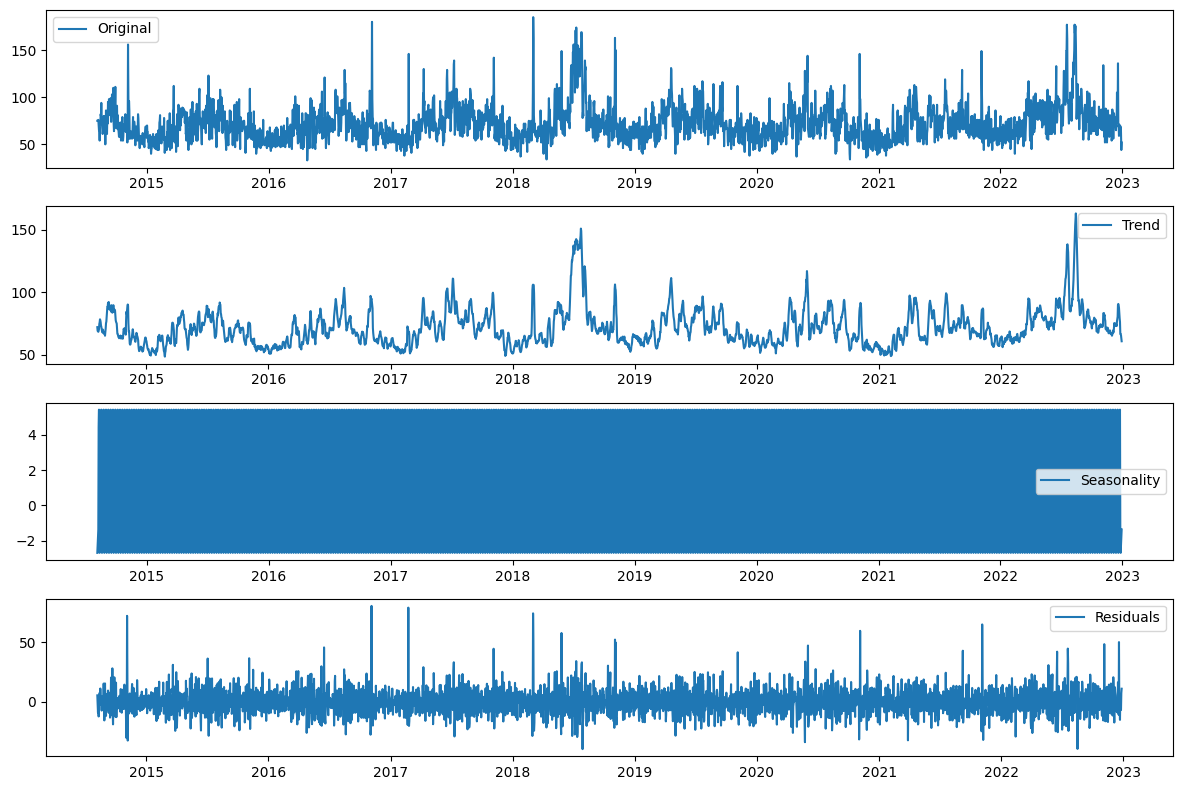

In [99]:
incident['call_time'] = pd.to_datetime(incident['call_time'])
incident.set_index('call_time', inplace=True)
# Resample the data to daily frequency and count the number of incidents per day
incidents_per_day = incident.resample('D').size()

# Perform seasonal decomposition
decomposition = seasonal_decompose(incidents_per_day, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(incidents_per_day, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

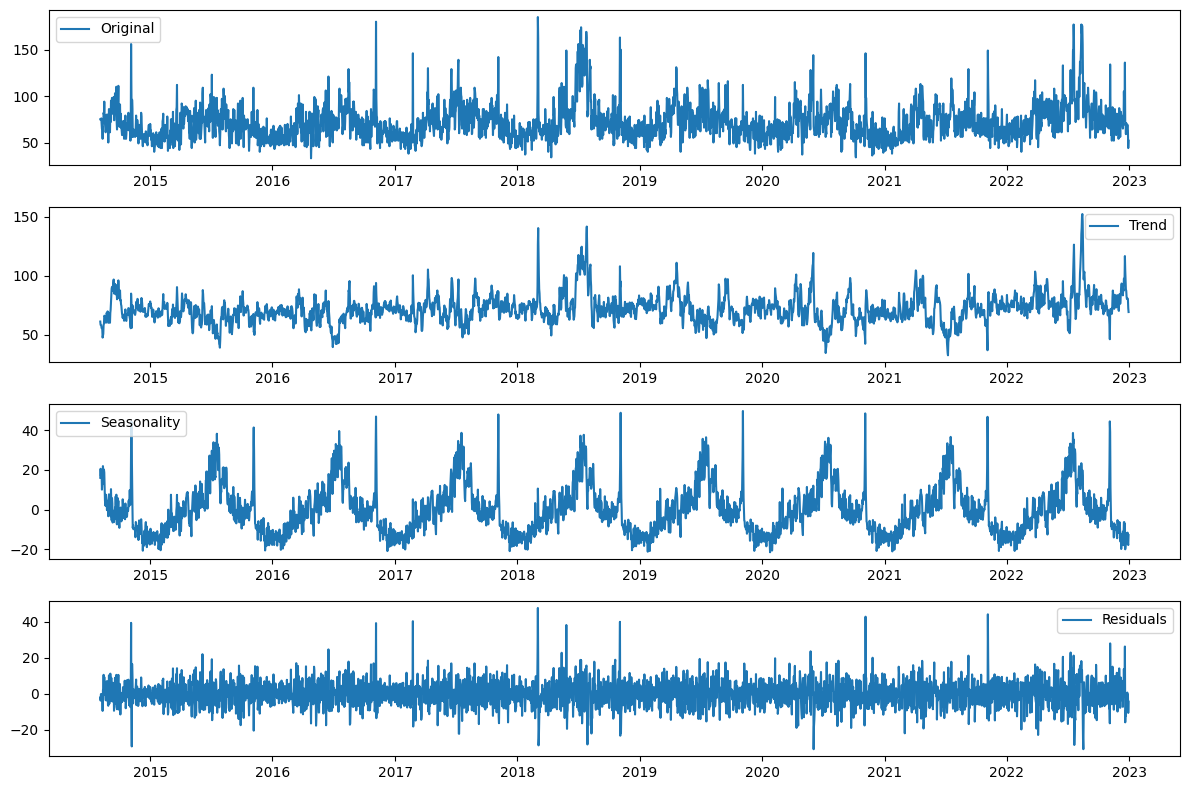

In [100]:
# Fit exponential smoothing model
model = ExponentialSmoothing(incidents_per_day, seasonal='add', seasonal_periods=365)
model_fit = model.fit()

# Extract trend, seasonal, and residual components
trend = model_fit.level
seasonal = model_fit.season
residual = incidents_per_day - trend - seasonal

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(incidents_per_day, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

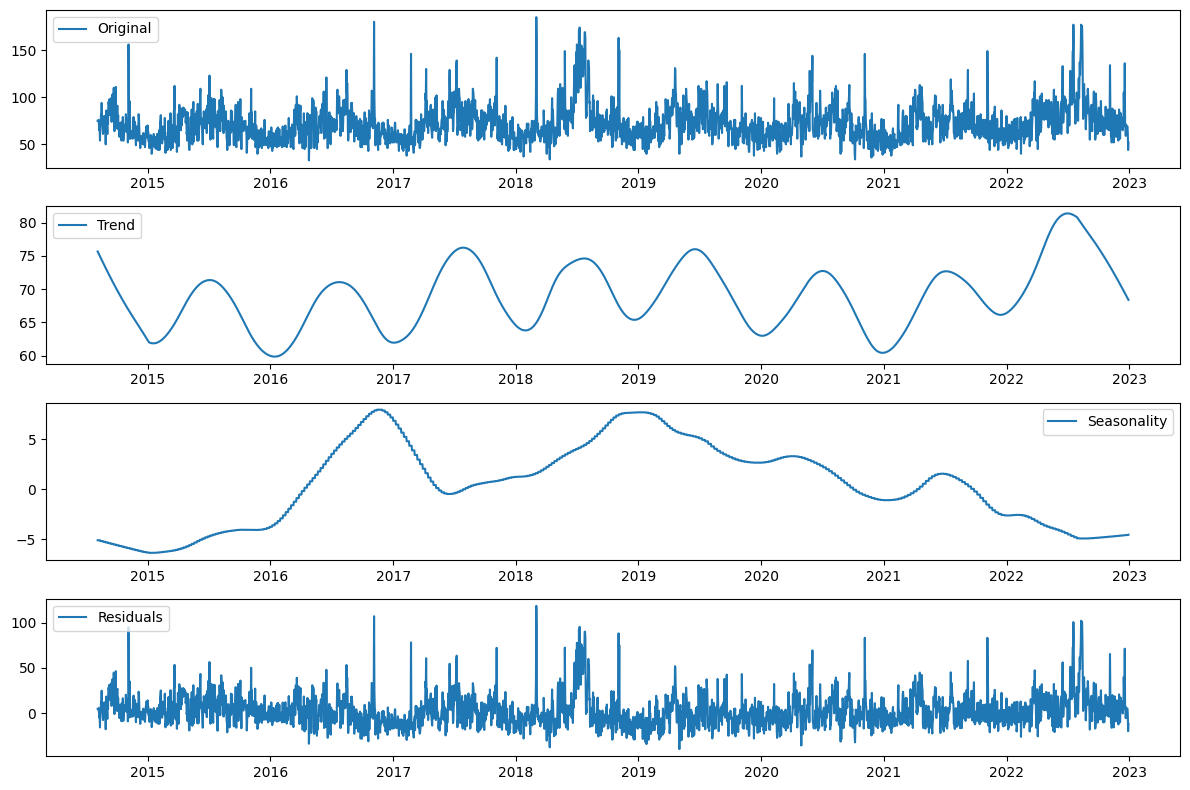

In [101]:
# Estimate trend using LOESS
trend = lowess(incidents_per_day, incidents_per_day.index, frac=0.1)[:, 1]

# Remove trend to get detrended data
detrended = incidents_per_day - trend

# Estimate seasonal component using LOESS on detrended data
seasonal = lowess(detrended, detrended.index.dayofyear, frac=0.1)[:, 1]

# Calculate residuals
residual = detrended - seasonal

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(incidents_per_day, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(incidents_per_day.index, trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(incidents_per_day.index, seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(incidents_per_day.index, residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


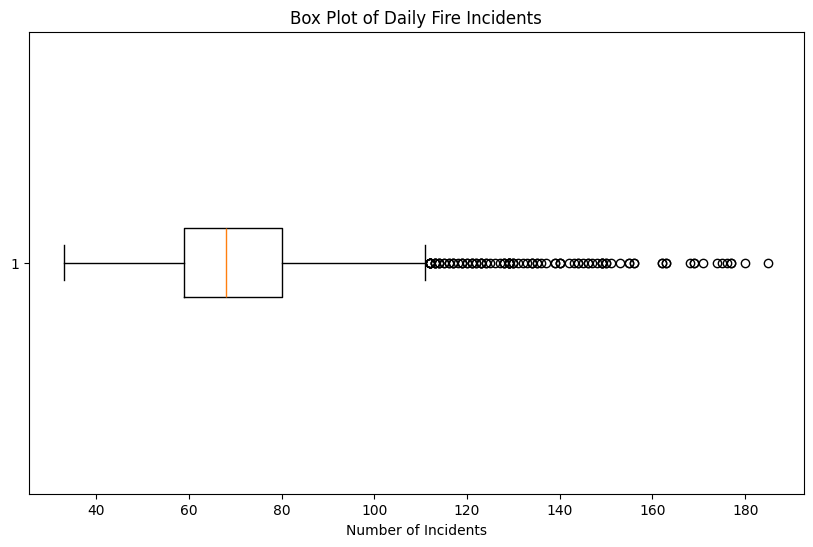

In [102]:
# Resample the data to daily frequency and count the number of incidents per day
incidents_per_day = incident.resample('D').size()

# Plot the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(incidents_per_day, vert=False)
plt.title('Box Plot of Daily Fire Incidents')
plt.xlabel('Number of Incidents')
plt.show()

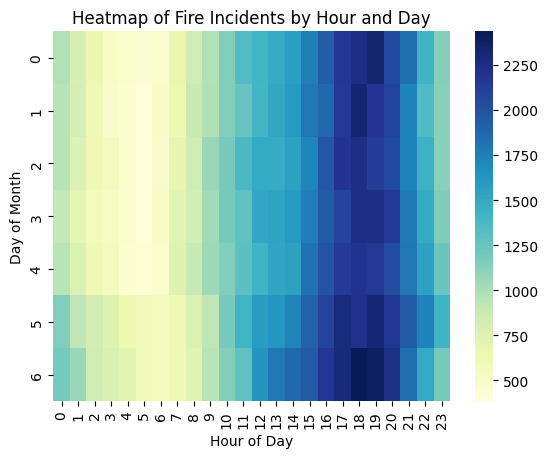

In [103]:
hourly_pivot = incident.pivot_table(values='prl_count', index='call_day', columns='call_hour', aggfunc='count')
sns.heatmap(hourly_pivot, cmap='YlGnBu')
plt.title('Heatmap of Fire Incidents by Hour and Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Month')
plt.show()

Outliers detection

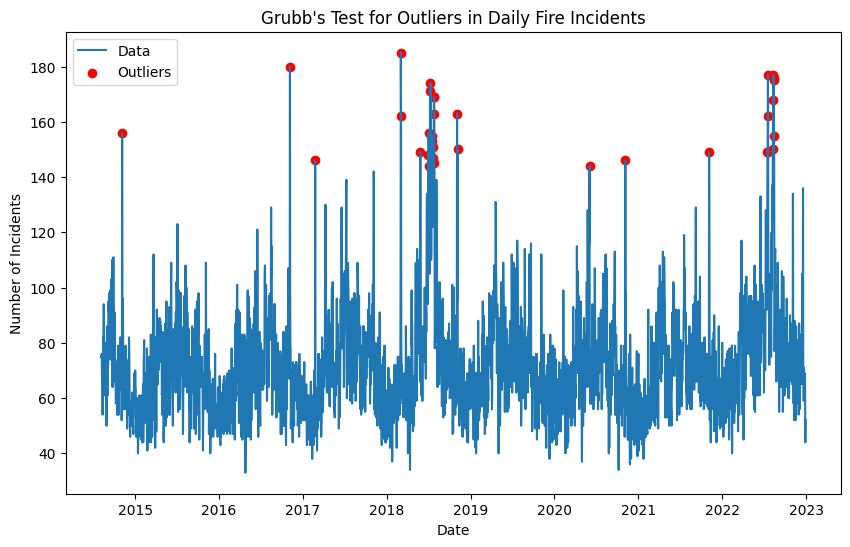

In [104]:
# Resample the data to daily frequency and count the number of incidents per day
incidents_per_day = incident.resample('D').size()

# Function to apply Grubb's test iteratively
def grubbs_test_series(data, alpha=0.05):
    outliers = []
    data_clean = data.copy()
    while True:
        n = len(data_clean)
        mean_y = np.mean(data_clean)
        std_y = np.std(data_clean)
        G = max(abs(data_clean - mean_y)) / std_y
        critical_value = stats.t.ppf(1 - alpha / (2 * n), n - 2) * (n - 1) / np.sqrt(n * (n - 2 + stats.t.ppf(1 - alpha / (2 * n), n - 2)**2))
        if G > critical_value:
            outlier_index = np.argmax(abs(data_clean - mean_y))
            outliers.append(data_clean.index[outlier_index])
            data_clean = data_clean.drop(data_clean.index[outlier_index])
        else:
            break
    return outliers

# Identify outliers
outlier_indices = grubbs_test_series(incidents_per_day)
outliers = incidents_per_day.loc[outlier_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(incidents_per_day, label='Data')
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.title("Grubb's Test for Outliers in Daily Fire Incidents")
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

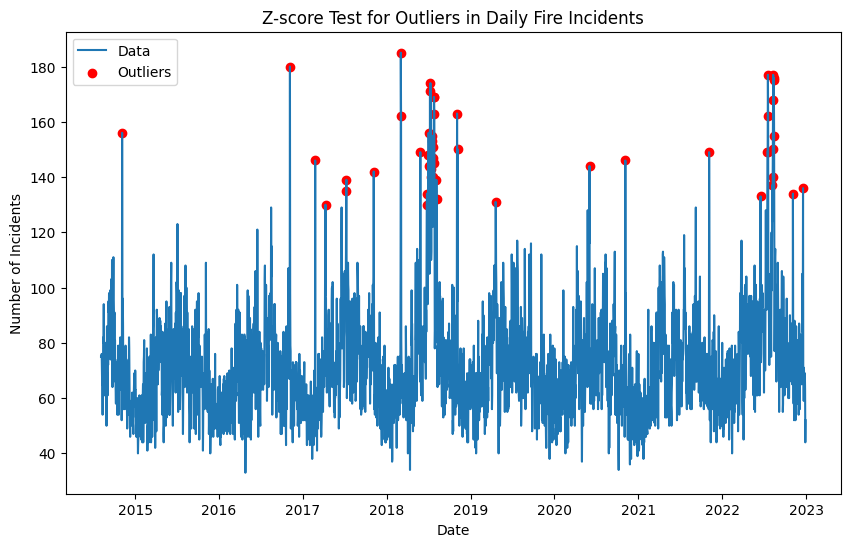

In [105]:
# Calculate Z-scores
z_scores = (incidents_per_day - incidents_per_day.mean()) / incidents_per_day.std()

# Define a threshold for Z-score
threshold = 3

# Identify outliers
outliers = incidents_per_day[np.abs(z_scores) > threshold]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(incidents_per_day, label='Data')
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.title('Z-score Test for Outliers in Daily Fire Incidents')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()


predictive model

ARIMA

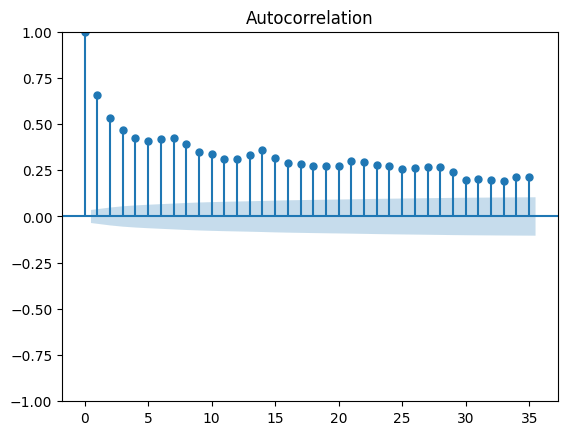

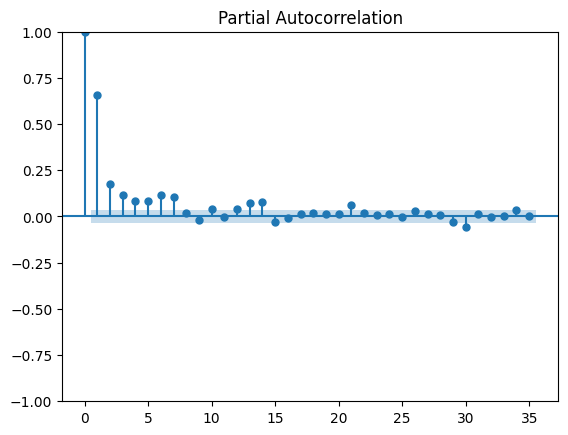

In [106]:
plot_acf(incidents_per_day)
plot_pacf(incidents_per_day)
plt.show()

In [107]:
model_arima = ARIMA(incidents_per_day, order=(1,0,0)) 
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3070
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -12558.847
Date:                  周四, 06 6月 2024   AIC                          25123.695
Time:                        04:53:02   BIC                          25141.783
Sample:                    08-05-2014   HQIC                         25130.193
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.6370      0.881     81.297      0.000      69.910      73.364
ar.L1          0.6571      0.010     67.593      0.000       0.638       0.676
sigma2       209.3155      3.424     61.137      0.0

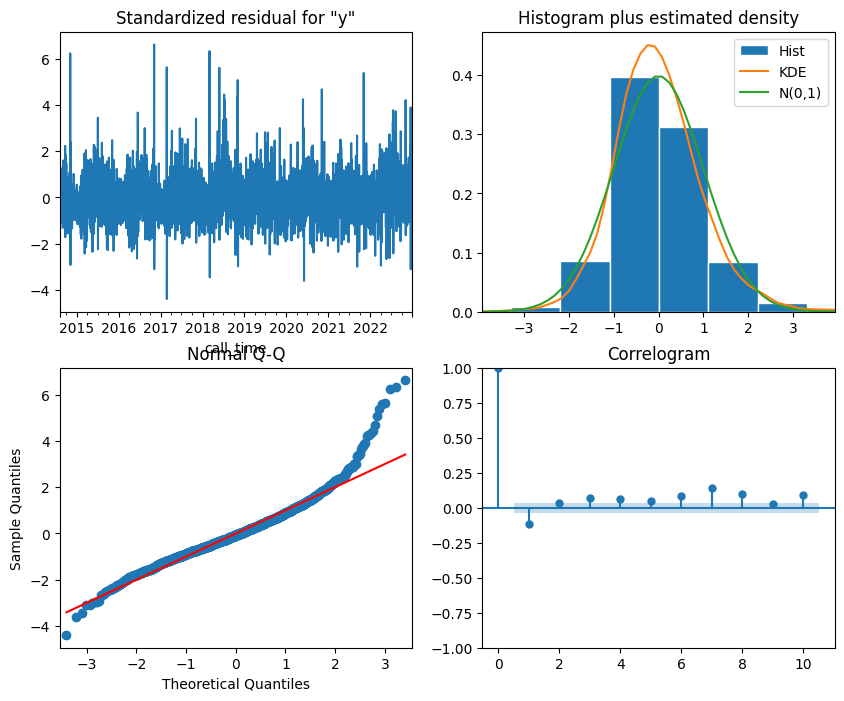

In [108]:
# Plot the residuals
model_arima_fit.plot_diagnostics(figsize=(10, 8))
plt.show()


In [109]:
predictions_arima = model_arima_fit.forecast(steps=365) 
print(predictions_arima)


2022-12-31    58.733857
2023-01-01    63.158560
2023-01-02    66.065958
2023-01-03    67.976360
2023-01-04    69.231653
                ...    
2023-12-26    71.636993
2023-12-27    71.636993
2023-12-28    71.636993
2023-12-29    71.636993
2023-12-30    71.636993
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


Mean Squared Error: 973.2256324713749
Mean Absolute Error: 27.257141596167525


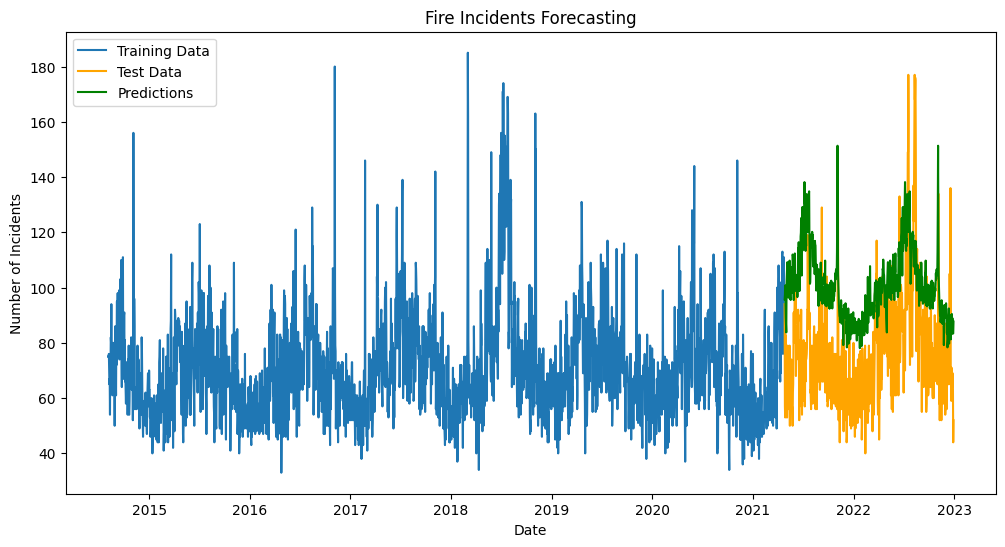

In [110]:
# Resample the data to daily frequency and count the number of incidents per day
incidents_per_day = incident.resample('D').size()

# Split the data into training and testing sets
train_size = int(len(incidents_per_day) * 0.8)
train_data, test_data = incidents_per_day[:train_size], incidents_per_day[train_size:]

# Fit the model
model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=365)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.plot(test_data.index, predictions, label='Predictions', color='green')
plt.legend(loc='best')
plt.title('Fire Incidents Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()


In [111]:
from fbprophet import Prophet

train_data_prophet = pd.DataFrame({'ds': train_data_arima.index, 'y': train_data_arima.values})
test_data_prophet = pd.DataFrame({'ds': test_data_arima.index, 'y': test_data_arima.values})

# fit the model
model_prophet = Prophet()
model_prophet.fit(train_data_prophet)

# predict
future = model_prophet.make_future_dataframe(periods=len(test_data_arima))
forecast = model_prophet.predict(future)
predictions_prophet = forecast[-len(test_data_arima):]['yhat'].values

plt.plot(test_data_arima.index, test_data_arima.values, label='Actual')
plt.plot(test_data_arima.index, predictions_prophet, label='Prophet Predictions', color='blue')
plt.title('Prophet Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()



ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Reshape data for LSTM
train_data_lstm = np.array(train_data).reshape(-1, 1)
test_data_lstm = np.array(test_data).reshape(-1, 1)

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Fit LSTM model
model_lstm.fit(train_data_lstm, train_data_lstm, epochs=100, batch_size=1, verbose=0)

# Make predictions
predictions_lstm = model_lstm.predict(test_data_lstm)
predictions_lstm = predictions_lstm.reshape(len(test_data))

# Evaluate the model
mse_lstm = mean_squared_error(test_data, predictions_lstm)
mae_lstm = mean_absolute_error(test_data, predictions_lstm)
print(f'LSTM Mean Squared Error: {mse_lstm}')
print(f'LSTM Mean Absolute Error: {mae_lstm}')


KeyboardInterrupt: 